In [4]:
from mumott.data_handling import DataContainer
from mumott import Geometry
import matplotlib.pyplot as plt
from mumott.core.spherical_harmonic_mapper import SphericalHarmonicMapper
from mumott.methods.projectors import SAXSProjector as Projector
from mumott.methods.basis_sets import GaussianKernels
from mumott.methods.utilities.preconditioning import get_largest_eigenvalue as matrix_norm_power_method
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.regularizers.group_lasso import GroupLasso
from mumott.pipelines.reconstruction.group_lasso import _ISTA as ISTA
import numpy as np
import h5py


In [5]:

q_index = 50

data_container = DataContainer(f'frogbone/dataset_qbin_{q_index:04d}.h5', nonfinite_replacement_value = 0)
with h5py.File(f'frogbone/dataset_qbin_{q_index:04d}.h5', 'r') as file:
    q =  float(file['q'][...])


INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


In [6]:
# Find good step-size parameter
bs = GaussianKernels(grid_scale = 3)
proj = Projector(data_container.geometry)
matrix_norm = matrix_norm_power_method(bs, proj)
print(matrix_norm)

# Optimization
stepsize_param =1/matrix_norm

2337.4967051270946


Loss = 2.92E+08: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


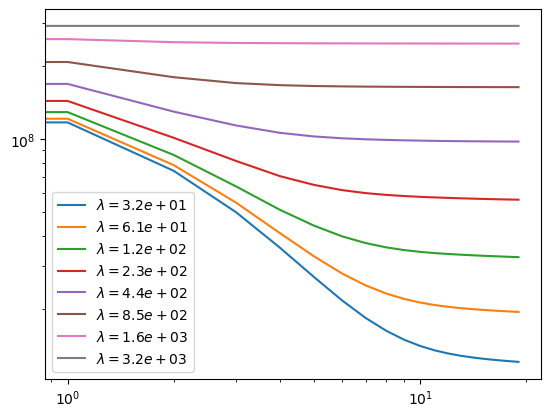

In [7]:
# Sweep regularization parameter
plt.figure()
regularization_params = np.logspace(1.5, 3.5, 8)
final_resid_norm = []
final_reg_norm = []
final_solution_norm = []
fraction_zero_voxels = []


f = SquaredLoss(GradientResidualCalculator(data_container, bs, proj))
for regularization_param in regularization_params:

    g = GroupLasso(regularization_param, stepsize_param)
    optimizer = ISTA(f, g, stepsize_param, maxiter = 20)
    opt_coeffs = optimizer.optimize()

    final_resid_norm.append(f.get_loss()['loss'])
    final_reg_norm.append(g.get_regularization_norm(opt_coeffs))
    final_solution_norm.append(np.sum(opt_coeffs**2))
    
    fraction_zero_voxels.append(np.sum(np.abs(opt_coeffs[..., 0]) < 1e-10) / np.product(opt_coeffs.shape[:3]))
    
    # Simple plotting
    plt.loglog(optimizer.error_function_history)
    
plt.legend([fr"$\lambda = {regularization_param:.1e}$" for regularization_param in regularization_params])
plt.show()


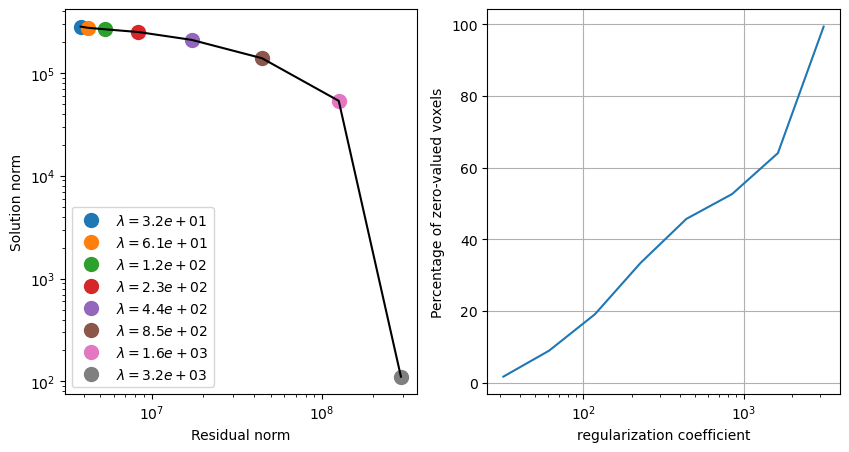

In [8]:
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
for sol_norm, resid_norm in zip(final_solution_norm, final_resid_norm):
    
    plt.loglog(resid_norm, sol_norm, '.', markersize = 20)
    
plt.legend([fr"$\lambda = {regularization_param:.1e}$" for regularization_param in regularization_params])

plt.loglog(final_resid_norm, final_solution_norm, 'k')
plt.ylabel('Solution norm')
plt.xlabel('Residual norm')


plt.subplot(1,2,2)

plt.semilogx(regularization_params, 100*np.array(fraction_zero_voxels))
plt.xlabel('regularization coefficient')
plt.grid()
plt.ylabel('Percentage of zero-valued voxels')
plt.show()

In [9]:
# Choose good regularization parameter and run for more iterations
regularization_param = 7e2
g = GroupLasso(regularization_param, stepsize_param)
optimizer = ISTA(f, g, stepsize_param, maxiter = 100)
opt_coeffs = optimizer.optimize()

Loss = 1.41E+08: 100%|██████████| 100/100 [07:55<00:00,  4.76s/it]


/das/home/carlse_m/mumott_dev_version/mumott/mumott/methods/basis_sets/gaussian_kernels.py:490: RuntimeWarning: invalid value encountered in divide
  fractional_anisotropy = fractional_anisotropy / np.sqrt(2*np.sum(eigenvalues**2, axis=-1))


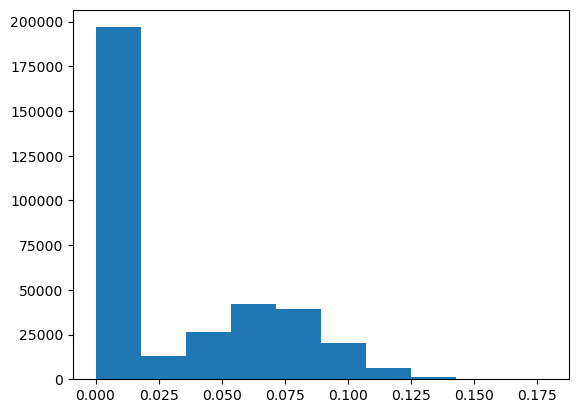

In [10]:
computed_quantities = bs.get_output(opt_coeffs)

plt.hist(computed_quantities.mean_intensity.ravel())
plt.show()

mask_threshold = 0.0
mask = computed_quantities.mean_intensity > mask_threshold

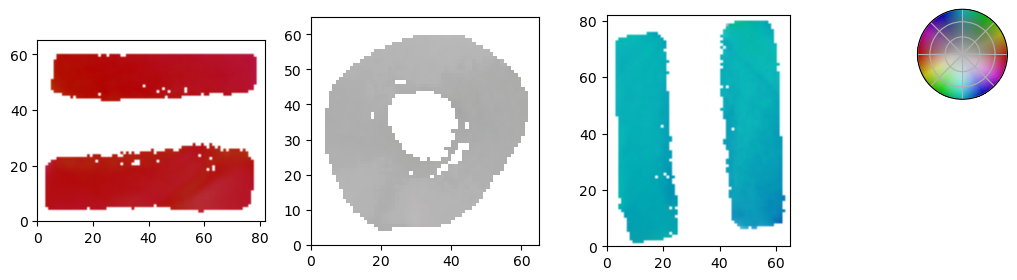

In [11]:
from mumott_plotting.tomogram_plots import plot_direction_in_slice, make_color_wheel
main_direction = computed_quantities.eigenvector_1

fig = plt.figure(figsize = (10,3))

ax = plt.subplot(1,3,1)
ax, _ = plot_direction_in_slice(main_direction, 30, 'yz' , mask=mask, ax = ax)
ax = plt.subplot(1,3,2)
ax, _ = plot_direction_in_slice(main_direction, 40, 'xz' , mask=mask, ax = ax)
ax = plt.subplot(1,3,3)
ax, _ = plot_direction_in_slice(main_direction, 30, 'xy' , mask=mask, ax = ax)

ax = fig.add_subplot([0.9, 0.6, 0.30, 0.30], polar = True)
make_color_wheel(ax)
ax.set_xticklabels([]); ax.set_yticklabels([])
plt.show()

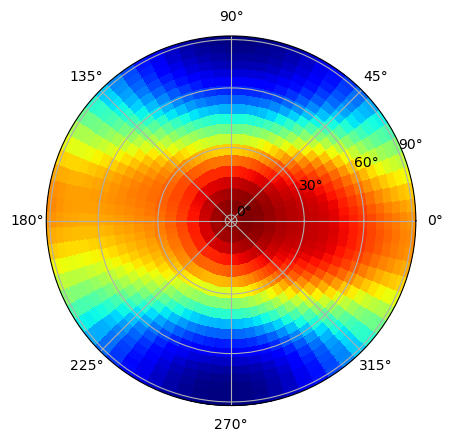

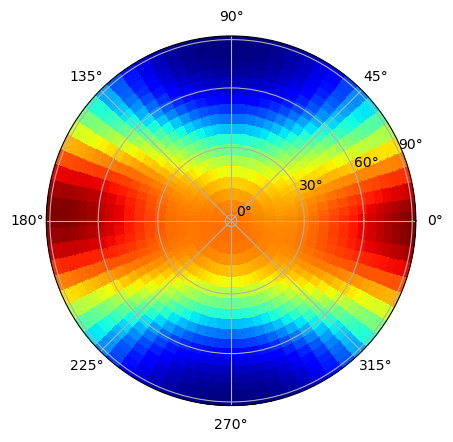

In [20]:
from mumott_plotting.map_plots import plot_on_polefigure


pf, theta, phi = bs.generate_map(opt_coeffs[35,40,10,:])
ax = plt.subplot(1,1,1,polar=True)

plot_on_polefigure(ax, pf, theta, phi)
plt.show()

pf, theta, phi = bs.generate_map(opt_coeffs[15,40,30,:])
ax = plt.subplot(1,1,1,polar=True)

plot_on_polefigure(ax, pf, theta, phi)
plt.show()